**In order to get the results i present in the report, you need to run everything up to Model Training and Results Section. After that, proceed with the face2sketch training (1) with the mse loss function. Once it finishes, on the same session, train the sketch2face model with the mse loss function (1).After that train the model again, with the face2sketch training block (2) with mae loss function and run all the blocks with the #Face2sketch comment in the Model Evaluation and Results section for the face2sketch results. Lastly, run the sketch2face (2) training, and get all the results for sketch 2 face. Due to the huge time that the training takes to run (45 minutes each training block), i will be giving you a link for a shared google drive folder that contains all the models for the report in their final form, so you can just load them and check the results. Feel free to follow the above process in order to confirm that the results check out.**

The files were organisation and the data augumentation (section "Load and pre-process the data") were taken from :

https://www.kaggle.com/theblackmamba31/photo-to-sketch-using-autoencoder/notebook



We first start by importing the needed libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras 
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, Flatten, Input, Reshape
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re

With the help of google.colab libarary we mount our drive to the files 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
#https://drive.google.com/drive/folders/1C2lQ61MssBmVjRxrzYy0vqDOMWWxSEex?usp=sharing  use that link to get data files in your drive to continoue running

Mounted at /content/gdrive/


# Load and pre-process the data

We make a function to sort our data first alphabetically and then numerically.
Then we specify the size of the image we are going to proceed with (256x256 pixels) and specify the images and sketches paths from our drive. After that we use the function we made to make two new sorted folders of both the images and sketches

In [3]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

image_path = "/content/gdrive/MyDrive/Data_for_CW1/photos"
img_array = []

sketch_path = '/content/gdrive/MyDrive/Data_for_CW1/sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))

Here we load our sorted data using cv2, which returns a numpy array in BGR. We change that to RGB, because most image software and cameras use RGB. After that we normalise the data in (0,1) range by dividing with 255 (0-255 is the range of every pixel value). The data we are provided only contain 188 photos and sketches for our training and testing. That is very low, so in order to overcome this weakness we use data augumentation (7 times for every image). That makes the new total of available images 1504 photos and the same sketches. We then load all the new data into 2 arrays.

In [4]:
for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    
    #Image Augmentation
    # horizontal flip 
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))

100%|██████████| 188/188 [00:48<00:00,  3.87it/s]


In [5]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))
print(len(img_array[1]))

Total number of sketch images: 1504
Total number of images: 1504
256


We then split the entire data into 2 parts, the training data and the testing data. The testing data is consisted of ~ 7% of the data sets and the rest 93% goes towards training our model. After splitting the data, we resize them into our desirable dimentions ((256,256) in this case).

In [6]:
train_sketch_image = sketch_array[:1400]
train_image = img_array[:1400]
test_sketch_image = sketch_array[1400:]
test_image = img_array[1400:]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Train color image shape: (1400, 256, 256, 3)
Test color image shape (104, 256, 256, 3)


In [15]:
#Load the model if you dont want to run the process again
from tensorflow.keras.models import load_model
AE_model = load_model('/content/gdrive/MyDrive/Data_for_CW1/MyModels/MyModel/sketch2faceMyModel.h5')

# Autoencoder Design

Next we make a function to that will help create the encoding "layers" of our autoencoder. Each layer will be composed of a sequential model that contains multiple layers with Conv2D as the main layer.

In [ ]:
def encoder_layer(filters, size, normalise = True, padding = "same", pooling = True, poolsize = 2):
  enc = tf.keras.models.Sequential()
  enc.add(keras.layers.Conv2D(filters = filters, kernel_size = (size,size), padding= padding, strides=1))
  if pooling:
    enc.add(keras.layers.MaxPooling2D(pool_size=(poolsize, poolsize), strides=2, padding="same"))
  enc.add(keras.layers.LeakyReLU())
  if normalise:
    enc.add(keras.layers.BatchNormalization())
  return enc

Next we make a function to that will help create the decoding "layers" of our autoencoder. Each "layer" will be composed of a sequential model that contains multiple layers with Conv2DTranspose as the main layer. (In order to decompress the information)

In [ ]:
def decoder_layer(filters, size, normalise = True, padding = "same"):
  dec = tf.keras.models.Sequential()
  dec.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = (size,size), padding = padding, strides=1))
  dec.add(keras.layers.UpSampling2D(size=(2,2)))
  dec.add(keras.layers.ReLU())
  if normalise:
    dec.add(keras.layers.BatchNormalization())
  return dec

We make the encoder separately from the decoder for easier access to changes

Here is the encoder structure

In [ ]:
dense_size = 512
enc_input = Input(shape = (SIZE, SIZE, 3))
enc = encoder_layer(256, 5)(enc_input)
enc = encoder_layer(128, 3, padding = "valid")(enc)
enc = encoder_layer(64, 3)(enc)
enc = encoder_layer(32, 3, padding = "valid")(enc)
enc = encoder_layer(16, 3)(enc)
enc = encoder_layer(8, 3)(enc)

last_size = K.int_shape(enc)
enc = Flatten()(enc)
enc_output = Dense(dense_size)(enc)

encoder = Model(enc_input,enc_output)

encoder.summary()


We now make the decoder 

Here is the decoder structure

In [ ]:
dec_input = Input(shape=(dense_size,))
dec = Dense(np.prod(last_size[1:]))(dec_input)
dec = Reshape((last_size[1], last_size[2], last_size[3]))(dec)
dec = decoder_layer(16, 3)(dec)
dec = decoder_layer(32, 3)(dec)
dec = decoder_layer(64, 3)(dec)
dec = decoder_layer(128, 3)(dec)
dec = decoder_layer(256, 5)(dec)
dec = UpSampling2D(size=(2,2))(dec)
dec_output = Conv2DTranspose(3, 3, padding='same', activation = "relu")(dec)

decoder = Model(dec_input,dec_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 reshape (Reshape)           (None, 4, 4, 8)           0         
                                                                 
 sequential_6 (Sequential)   (None, 8, 8, 16)          1232      
                                                                 
 sequential_7 (Sequential)   (None, 16, 16, 32)        4768      
                                                                 
 sequential_8 (Sequential)   (None, 32, 32, 64)        18752     
                                                                 
 sequential_9 (Sequential)   (None, 64, 64, 128)       7436

And now we merge them into one model, our autoencoder

In [ ]:
AE_input = enc_input
AE_output =  decoder(enc_output)
AE_model = Model(AE_input, AE_output)
AE_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 256)     20480     
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 128)       295552    
                                                                 
 sequential_2 (Sequential)   (None, 32, 32, 64)        74048     
                                                                 
 sequential_3 (Sequential)   (None, 16, 16, 32)        18592     
                                                                 
 sequential_4 (Sequential)   (None, 8, 8, 16)          4688      
                                                                 
 sequential_5 (Sequential)   (None, 4, 4, 8)           1192

# Model Training and Results

Now we start the training process

In [ ]:
#Face2sketch (1)
AE_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error',
              metrics = ['mae', "acc"])

hist = AE_model.fit(train_image, train_sketch_image, epochs = 100, verbose = 1)

In [ ]:
#Face2sketch (2)
AE_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['mae', "acc"])

hist = AE_model.fit(train_image, train_sketch_image, epochs = 50, verbose = 1)

In [ ]:
#Sketch2face (1)
AE_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error',
              metrics = ['acc'])

hist2 = AE_model.fit(train_sketch_image, train_image, epochs = 100, verbose = 1)

In [ ]:
#Sketch2face (2)
AE_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

hist2 = AE_model.fit(train_sketch_image, train_image, epochs = 50, verbose = 1)

# Model Evaluation and Results

Loss and accuracy calculation

In [10]:
#Face2sketch
prediction_on_test_data = AE_model.evaluate(test_image, test_sketch_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[2] * 100,1))

4/4 [==============================] - 10s 180ms/step - loss: 0.0899 - mae: 0.0899 - acc: 0.4705
Loss:  0.0899292528629303
Accuracy:  47.0


In [16]:
#Sketch2face
prediction_on_test_data = AE_model.evaluate(test_sketch_image, test_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

4/4 [==============================] - 1s 100ms/step - loss: 0.0837 - acc: 0.9092
Loss:  0.0836871862411499
Accuracy:  90.9


Plot the loss

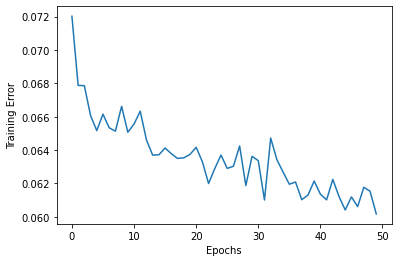

In [ ]:
#Face2Sketch
plt.plot(hist.history["loss"]);
plt.xlabel('Epochs');
plt.ylabel('Training Error');

In [ ]:
#Sketch2Face
plt.plot(hist2.history["loss"]);
plt.xlabel('Epochs');
plt.ylabel('Training Error');

Plot Mae 

In [ ]:
#Face2Sketch
plt.plot(hist.history["mae"]);
plt.xlabel('Epochs');
plt.ylabel('Mean Absolute Error');

In [ ]:
#Sketch2Face
plt.plot(hist2.history["mae"]);
plt.xlabel('Epochs');
plt.ylabel('Mean Absolute Error');

Plot accuracy

In [ ]:
#Face2Sketch
plt.plot(hist.history["acc"]);
plt.xlabel('Epochs');
plt.ylabel('Mean Absolute Error');

In [ ]:
#Sketch2Face
plt.plot(hist2.history["acc"]);
plt.xlabel('Epochs');
plt.ylabel('Mean Absolute Error');

Function to compare the predicted and original images

In [11]:
#Face2sketch
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

In [17]:
#Sketch2face
def show_images(sketch, real, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Sketch",fontsize = 15, color = 'Lime')
    plt.imshow(sketch)
    plt.subplot(1,3,2)
    plt.title("Image",fontsize = 15, color = 'Blue')
    plt.imshow(real)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

Comparison

In [ ]:
#Face2sketch
ls = [i for i in range(0,95,8)]
for i in ls:
    predicted =np.clip(AE_model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)

In [ ]:
#Sketch2face
pred = []
ls = [i for i in range(0,95,8)]
for i in ls:
    predicted =np.clip(AE_model.predict(test_sketch_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    pred.append(predicted)
    show_images(test_sketch_image[i],test_image[i],predicted)
pred = np.array(pred)

Evaluation of similarity

In [13]:
#face2sketch
pred = []
for i in range(0,104):
  predicted =np.clip(AE_model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
  pred.append(predicted)

In [19]:
#sketch2face
pred = []
for i in range(0,104):
  predicted =np.clip(AE_model.predict(test_sketch_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
  pred.append(predicted)

In [20]:
from skimage.metrics import structural_similarity as ssim1
SSIMarray = []
sumssim = 0
for i in range(0, 104):
  SSIM = ssim1(test_image[i], pred[i], multichannel=True)
  SSIMarray.append(SSIM)
  sumssim+= SSIM

avgssim = sumssim/104
print("SSIM =",avgssim)

from sklearn.metrics import mean_squared_error as mse1
import math
RMSEarray = []
sumrmse = 0

t = np.reshape(test_image, (104,-1))
p = np.reshape(pred, (104,-1))

for i in range(0, 104):
  MSE = mse1(t[i], p[i])
  RMSEarray.append(math.sqrt(MSE))
  sumrmse+= math.sqrt(MSE)

avgrmse = sumrmse/104
print("RMSE =",avgrmse)

from sklearn.metrics import median_absolute_error as mae

maearray = []
summae = 0

for i in range(0, 104):
  MAE = mae(t[i], p[i])
  maearray.append(MAE)
  summae+= MAE

avgrmae = summae/104
print("MAE =",avgrmae)



SSIM = 0.801092958767452
RMSE = 0.13046347005790906
MAE = 0.05472004055403746


Save the models

In [ ]:
#Face2sketch
AE_model.save('/content/gdrive/MyDrive/MyModels/MyModel/face2sketchMyModel.h5')

In [ ]:
#Sketch2face
AE_model.save("/content/gdrive/MyDrive/MyModels/MyModel/sketch2faceMyModel.h5")